In [263]:
import numpy
numpy.seterr(all='ignore')
import iris
iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True
import warnings
warnings.simplefilter('ignore')

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import sys
import datetime
import time
import netCDF4 as nc
import pickle

In [3]:
from cis.data_io.gridded_data import GriddedDataList
from cis.data_io.ungridded_data import UngriddedDataList
from cis.data_io.gridded_data import GriddedData
from cis import read_data, read_data_list, get_variables
from cis.data_io.Coord import Coord
from cis.data_io.ungridded_data import Metadata

In [260]:
from shapely.geometry import box

In [235]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

In [181]:
# These are the regions of interest

sea_decks = box(-12.5, -30, 12, -5)
peru_decks = box(-100, -30, -80, -10)

### What's in the data?

The data set we're loading has been filtered using CAD scores and Extinction QC flag provided for the CALIOP L2 product to find columns with high classification confidence. This data set also only contains CALIPSO swaths that intersect our regions of interest. All extinction profiles are 532nm for now.

In [101]:
with open('data/subsets/filtered_peru_ext532_jan.pkl', 'rb') as b:
    ext532_filt_peru = pickle.load(b)
    
with open('data/subsets/filtered_sea_ext532_jan.pkl', 'rb') as b:
    ext532_filt_sea = pickle.load(b)

Here's a preview of the swaths we have for the South East Atlantic (SEA). 

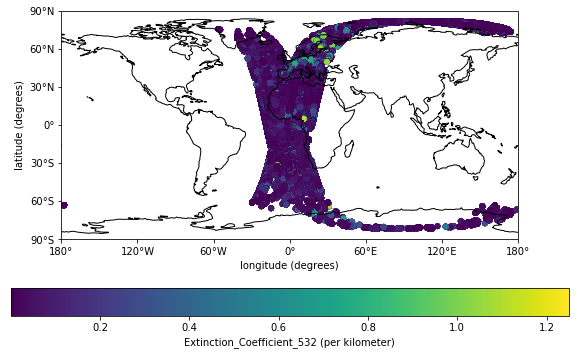

In [102]:
ext532_filt_sea[0].plot()

Here's some more detail. Notice that the altitude coordinate has been preserved here. 

In [183]:
print(ext532_filt_sea[0])

Ungridded data: Extinction_Coefficient_532 / (per kilometer) 
     Shape = (69652, 399)

     Total number of points = 27791148
     Number of non-masked points = 1797058
     Long name = 
     Standard name = None
     Units = per kilometer
     Missing value = None
     Range = (7.379687e-09, 1.2495824)
     History = 
     Misc attributes: 
       Format = Float_32
       Valid_Range = 0.0...1.25
       Fillvalue = -9999.0
     Coordinates: 
       latitude
          Long name = 
          Standard name = latitude
          Units = degrees
          Missing value = None
          Range = (-81.83576, 81.84029)
          History = 
          Misc attributes: 
            Format = Float_32
            Valid_Range = -90.0...90.0
       longitude
          Long name = 
          Standard name = longitude
          Units = degrees
          Missing value = None
          Range = (-178.03879, 178.83618)
          History = 
          Misc attributes: 
            Format = Float_32
        

### Integrate profiles 

Here we integrate the extinction coefficient over different height ranges, trying to take into account the different CALIPSO quirks (this might get updated).  

In [184]:
STRATOSPHERE_INDEX = 53
TOTAL_LAYERS = 399
VERTICAL_SPACING = Coord(np.concatenate([np.ones(STRATOSPHERE_INDEX) * 0.180,
                                         np.ones(TOTAL_LAYERS-STRATOSPHERE_INDEX) * 0.060]),
                         metadata=Metadata(units='km'))

unit_standardisation = {"per kilometer": 'km-1'}

In [185]:
def fix_units(data):
    if data.units in unit_standardisation:
        data.units = unit_standardisation[data.units]

def integrate_profile(data, height_range, name=None, spacing=VERTICAL_SPACING):
    """
    Integrage a CALIOP vertical profile using the standard (two level) vertical resolution
    
    :param UngriddedData data: 2D profile data *retaining the 2D array structure*
    :return UngriddedData: 1D integrated swath
    """
    # TODO: Ideally we would be able to just collapse the altitude dimension, but this isn't a gridded dataset...
    fix_units(data)
    extinction_surface = data[:, 0]

    # TODO: check if this is the right way to access heights - i.e. are the values reported for a range of heights or what
    
    # extract indices where height in given height range
    heights = data.coord('altitude').data[0, :]
    idx = np.where(np.logical_and(heights > height_range[0], heights < height_range[1]))[0]
    
    # use these indices to subset the extinction data 
    integrated_data = extinction_surface
    integrated_data.data = np.ma.sum(data.data[:, idx] * spacing.data[idx], axis=1)
    integrated_data.units = data.units * spacing.units
    
    if name != None:
        integrated_data.var_name = 'aot_' + name
        
    # Take off the altitude coordinate so that I can combine it with the AOD variable
    integrated_data._coords.pop(-1)

    return integrated_data

In [192]:
sea_jan_A = integrate_profile(ext532_filt_sea[0], (0., 500.), '0_500')
sea_jan_B = integrate_profile(ext532_filt_sea[0], (500., 1000.), '500_1000')
sea_jan_C = integrate_profile(ext532_filt_sea[0], (1000., 1500.), '1000_1500')
sea_jan_D = integrate_profile(ext532_filt_sea[0], (1500., 2000.), '1500_2000')
sea_jan_E = integrate_profile(ext532_filt_sea[0], (2000., 2500.), '2000-2500')
sea_jan_F = integrate_profile(ext532_filt_sea[0], (2500., 3000.), '2500-3000')
sea_jan_G = integrate_profile(ext532_filt_sea[0], (3000., 3500.), '3000-3500')
sea_jan_H = integrate_profile(ext532_filt_sea[0], (3500., 4000.), '3500-4000')

In [190]:
peru_jan_A = integrate_profile(ext532_filt_peru[0], (0., 500.), '0_500')
peru_jan_B = integrate_profile(ext532_filt_peru[0], (500., 1000.), '500_1000')
peru_jan_C = integrate_profile(ext532_filt_peru[0], (1000., 1500.), '1000_1500')
peru_jan_D = integrate_profile(ext532_filt_peru[0], (1500., 2000.), '1500_2000')
peru_jan_E = integrate_profile(ext532_filt_peru[0], (2000., 2500.), '2000-2500')
peru_jan_F = integrate_profile(ext532_filt_peru[0], (2500., 3000.), '2500-3000')
peru_jan_G = integrate_profile(ext532_filt_peru[0], (3000., 3500.), '3000-3500')
peru_jan_H = integrate_profile(ext532_filt_peru[0], (3500., 4000.), '3500-4000')

In [193]:
sea_aots = UngriddedDataList([sea_jan_A, sea_jan_B, sea_jan_C, sea_jan_D, 
                             sea_jan_E, sea_jan_F, sea_jan_G, sea_jan_H])

In [194]:
peru_aots = UngriddedDataList([peru_jan_A, peru_jan_B, peru_jan_C, peru_jan_D,
                               peru_jan_E, peru_jan_F, peru_jan_G, peru_jan_H])

### Aggregated AOTs 

Here I aggregate the ungridded data to 0.5 x 0.5 degree grids. This is really only useful to see what happens at different altitudes and compare the two regions.

In [265]:
agg_sea_aots = sea_aots.aggregate(x=[-12.5,12.0,0.5], y=[-35.0,-5.0,0.5])
agg_peru_aots = peru_aots.aggregate(x=[-100.,-80.0,0.5], y=[-30.0,-10.0,0.5])

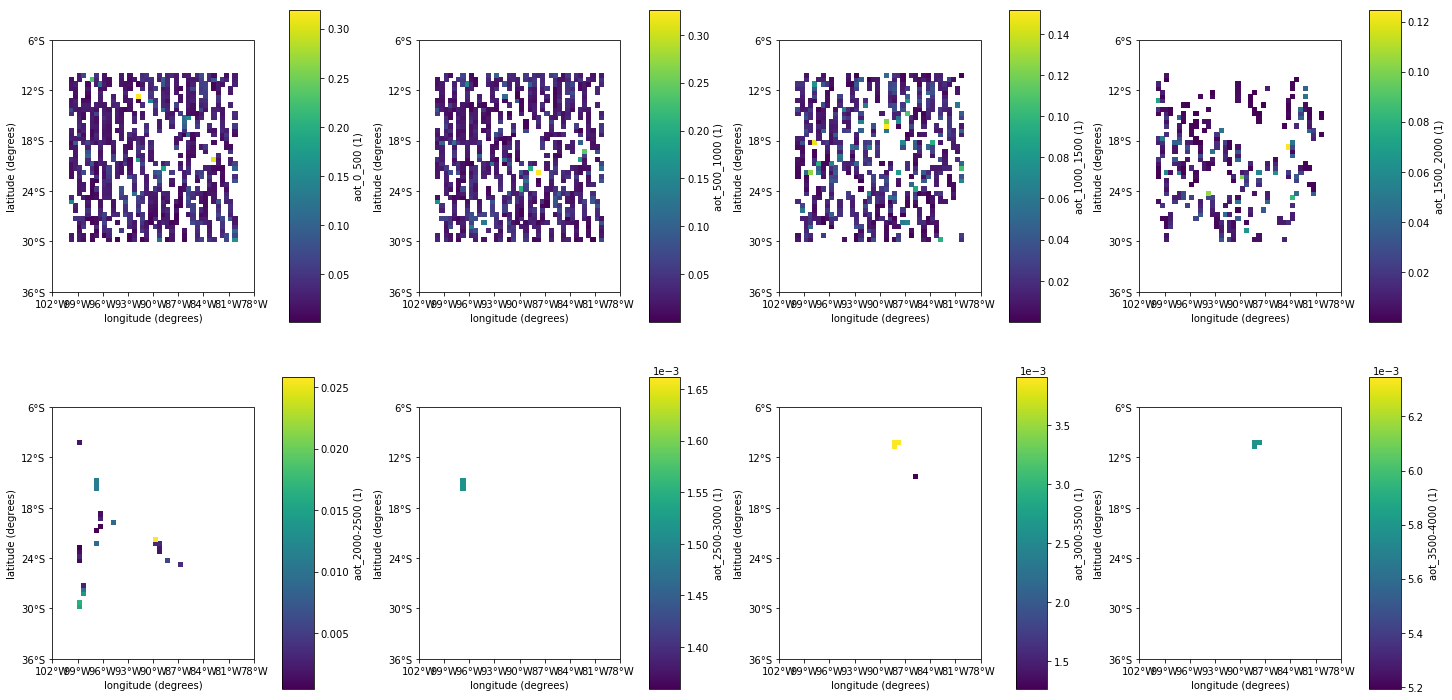

In [236]:
# fig = plt.figure()
fig1, axes = plt.subplots(ncols=4, nrows=2,  constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})

agg_peru_aots[0].plot(ax=axes[0, 0])

agg_peru_aots[3].plot(ax=axes[0, 1])

agg_peru_aots[6].plot(ax=axes[0, 2])

agg_peru_aots[9].plot(ax=axes[0, 3])

agg_peru_aots[12].plot(ax=axes[1, 0])

agg_peru_aots[15].plot(ax=axes[1, 1])

agg_peru_aots[18].plot(ax=axes[1, 2])

agg_peru_aots[21].plot(ax=axes[1, 3])

plt.show()

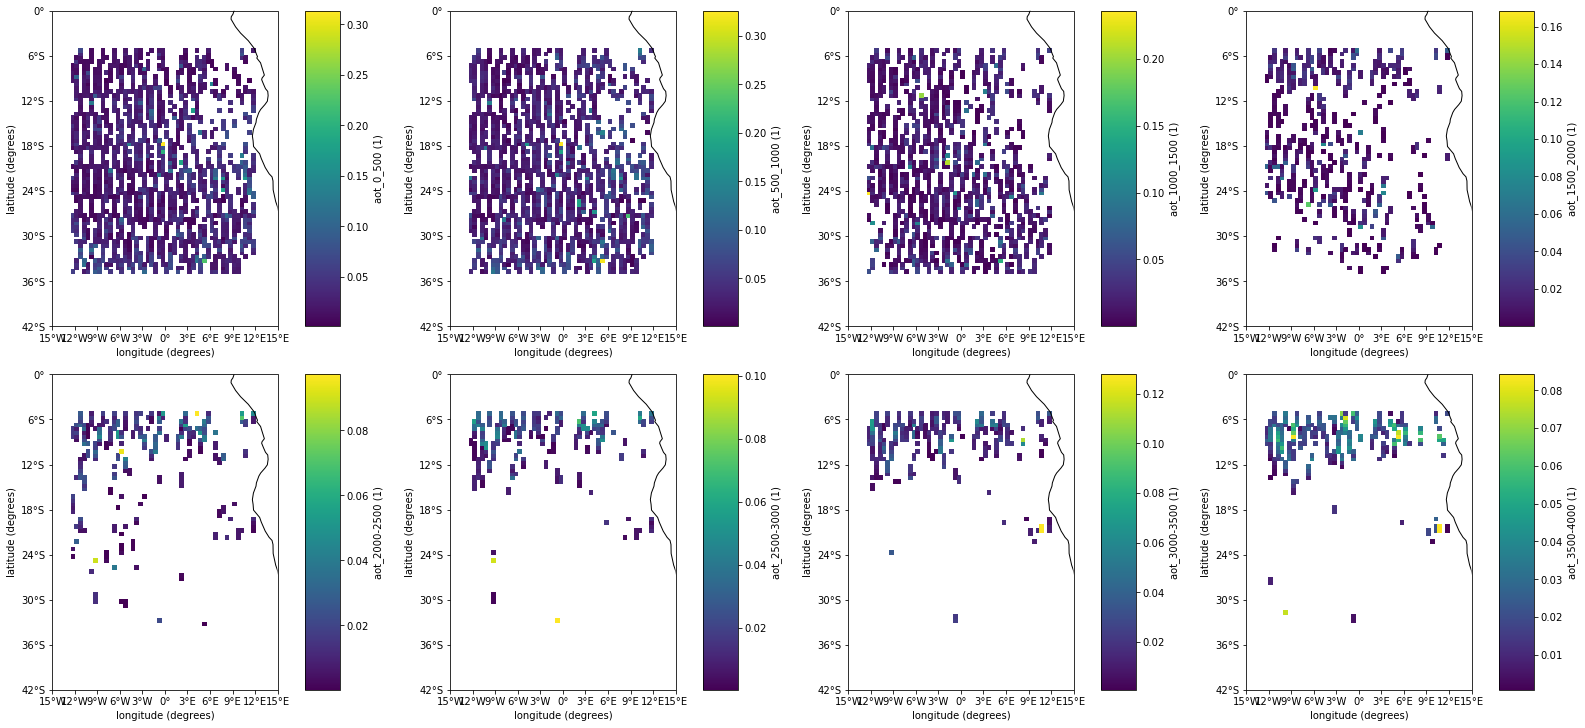

In [341]:
fig1, axes = plt.subplots(ncols=4, nrows=2,  figsize= (22, 10), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})

agg_sea_aots[0].plot(ax=axes[0, 0])

agg_sea_aots[3].plot(ax=axes[0, 1])

agg_sea_aots[6].plot(ax=axes[0, 2])

agg_sea_aots[9].plot(ax=axes[0, 3])

agg_sea_aots[12].plot(ax=axes[1, 0])

agg_sea_aots[15].plot(ax=axes[1, 1])

agg_sea_aots[18].plot(ax=axes[1, 2])

agg_sea_aots[21].plot(ax=axes[1, 3])

plt.show()

### Correlations with MODIS AOD

Integrated AOTs are collocated onto a 1x1 degree grid of the MODIS level 3 daily product.

In [239]:
mod_files_a = glob.glob('data/MYD08_D3/2010/00*/' + '*.hdf')
mod_files_b = glob.glob('data/MYD08_D3/2010/01*/' + '*.hdf')
mod_files_c = glob.glob('data/MYD08_D3/2010/02*/' + '*.hdf')

In [240]:
mod_fls_jan = mod_files_a + mod_files_b + mod_files_c + glob.glob('data/MYD08_D3/2010/030/' + '*.hdf') + glob.glob('data/MYD08_D3/2010/031/' + '*.hdf')

In [305]:
mod_aods = read_data_list(mod_fls_jan, ['AOD_550_Dark_Target_Deep_Blue_Combined_Mean', "Aerosol_Optical_Depth_Land_Ocean_Mean"])

In [241]:
mod_aod550_peru = mod_aods[0].subset(x=[-100., -80.], y=[-30., -10.])
mod_LO_aod_peru = mod_aods[1].subset(x=[-100., -80.], y=[-30., -10.])

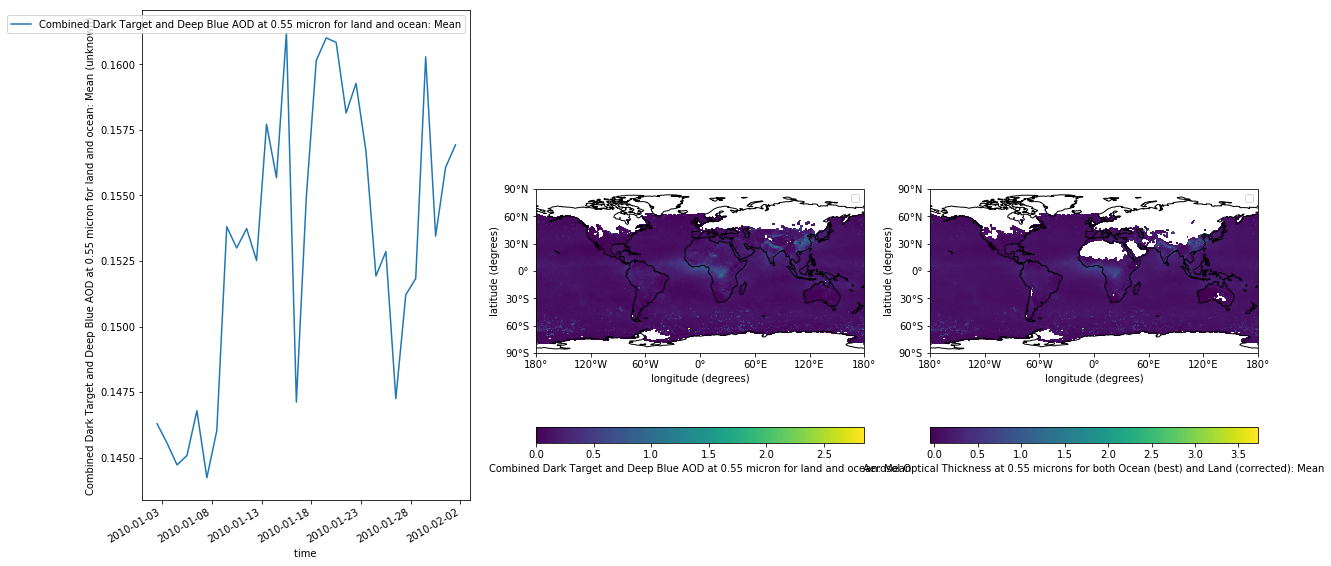

In [259]:
# inspect MODIS aods

from iris.analysis.cartography import area_weights

# mod_aods[0].coord('latitude').guess_bounds()
# mod_aods[0].coord('longitude').guess_bounds()

cell_weights = area_weights(mod_aods[0])

global_mean = mod_aods[0].collapsed(['latitude', 'longitude'],
                             iris.analysis.MEAN,
                             weights=cell_weights)
aod_550_jan_mean = mod_aods[0].collapsed('time', iris.analysis.MEAN)
aod_land_ocean_jan_mean = mod_aods[1].collapsed('time', iris.analysis.MEAN)

ax1 = plt.subplot(131)
global_mean.plot(ax=ax1)

ax2 = plt.subplot(132, projection=ccrs.PlateCarree())
aod_550_jan_mean.plot(ax=ax2)

ax3 = plt.subplot(133, projection=ccrs.PlateCarree())
aod_land_ocean_jan_mean.plot(ax=ax3)

plt.show()

In [247]:
aod_grid_peru = GriddedData.make_from_cube(mod_aod550_peru)

In [248]:
# needs to be transposed bc of a bug in cis

aod_grid_peru.transpose()
aots_aod550_peru = peru_aots.collocated_onto(aod_grid_peru)

In [249]:
col_aots_aod550_peru = aots_aod550_peru[::3]
col_aots_aod550_peru.append(aod_grid_peru)

Here's an example of one day of the spatially and temporaly collocated january data for the bottom (0-500m) layer for the Peruvian decks. The leftmost plot shows the AOT values for the grid points, middle is the corrected standard deviation of these, and the last plot shows how many samples were averaged for each grid point. 

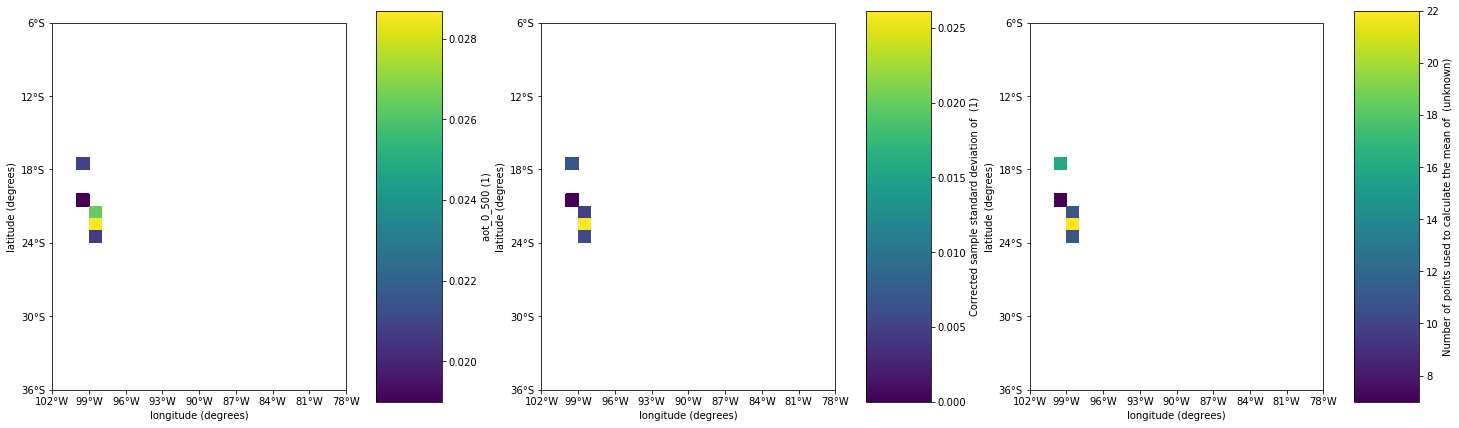

In [340]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})

GriddedData.make_from_cube(aots_aod550_peru[0][:,:,0]).plot(ax=axes[0])

GriddedData.make_from_cube(aots_aod550_peru[1][:,:,0]).plot(ax=axes[1])

GriddedData.make_from_cube(aots_aod550_peru[2][:,:,0]).plot(ax=axes[2])

plt.show()

In [95]:
def linear_fit(x, y, ax):
    z = np.polyfit(x.flatten(), y.flatten(), 1)
    p = np.poly1d(z)
    ax.plot(x,p(y),"r--")

Finally the correlations between integrated extinctions at different altitude ranges and the collocated MODIS AOD550 product. We see here that for the Peruvian decks in January there are very few collocated data points above 2000km.

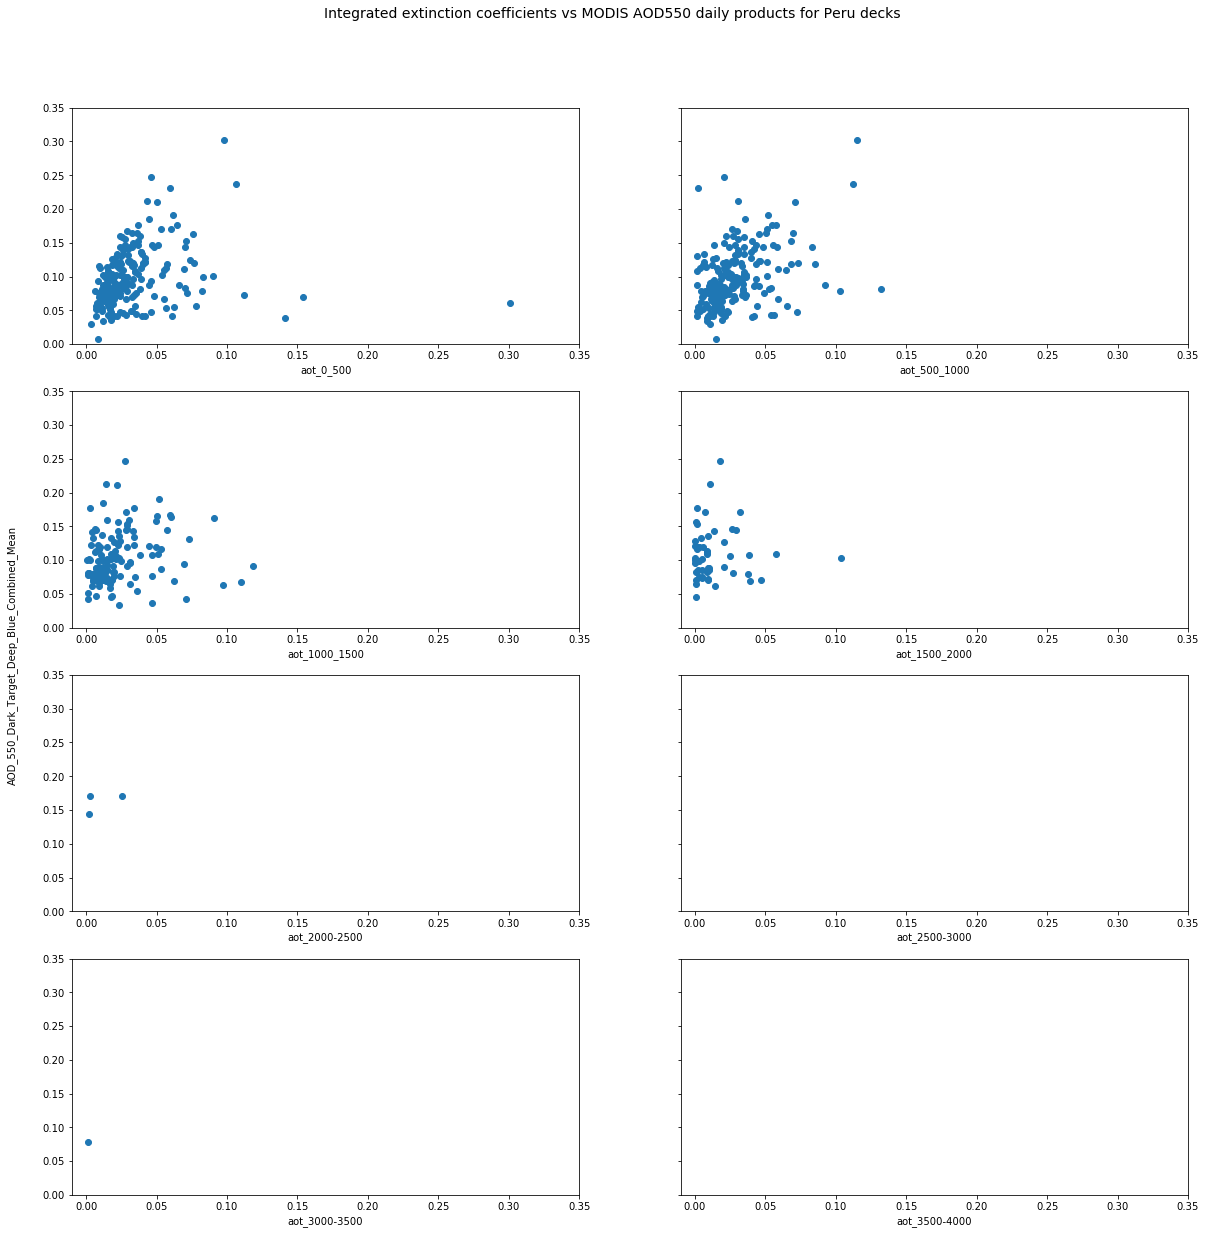

In [390]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharey=True)

plt.suptitle('Integrated extinction coefficients vs MODIS AOD550 daily products for Peru decks', y=0.95, fontsize=14)

axes[0, 0].scatter(col_aots_aod550_peru[0].data, col_aots_aod550_peru[-1].data)
axes[0, 0].set_xlabel(col_aots_aod550_peru[0].var_name)

axes[0, 1].scatter(col_aots_aod550_peru[1].data, col_aots_aod550_peru[-1].data)
axes[0, 1].set_xlabel(col_aots_aod550_peru[1].var_name)

axes[1, 0].scatter(col_aots_aod550_peru[2].data, col_aots_aod550_peru[-1].data)
axes[1, 0].set_xlabel(col_aots_aod550_peru[2].var_name)

axes[1, 1].scatter(col_aots_aod550_peru[3].data, col_aots_aod550_peru[-1].data)
axes[1, 1].set_xlabel(col_aots_aod550_peru[3].var_name)

axes[2, 0].scatter(col_aots_aod550_peru[4].data, col_aots_aod550_peru[-1].data)
axes[2, 0].set_xlabel(col_aots_aod550_peru[4].var_name)

axes[2, 1].scatter(col_aots_aod550_peru[5].data, col_aots_aod550_peru[-1].data)
axes[2, 1].set_xlabel(col_aots_aod550_peru[5].var_name)

axes[3, 0].scatter(col_aots_aod550_peru[6].data, col_aots_aod550_peru[-1].data)
axes[3, 0].set_xlabel(col_aots_aod550_peru[6].var_name)

axes[3, 1].scatter(col_aots_aod550_peru[7].data, col_aots_aod550_peru[-1].data)
axes[3, 1].set_xlabel(col_aots_aod550_peru[7].var_name)

plt.setp(axes, xlim=(-0.01, 0.35), ylim=(0, 0.35))
fig.text(0.08, 0.5, col_aots_aod550_peru[-1].var_name, va='center', rotation='vertical')
plt.show()

In [306]:
mod_aod550_sea = mod_aods[0].subset(x=[-12.5, 12.], y=[-30., -5.])
mod_LO_aod_sea = mod_aods[1].subset(x=[-12.5, 12.], y=[-30., -5.])

In [307]:
# scatters in SEA
aod550_grid_sea = GriddedData.make_from_cube(mod_aod550_sea)

In [308]:
aod550_grid_sea.transpose()
aots_aod550_sea = sea_aots.collocated_onto(aod550_grid_sea)

In [309]:
col_aots_aod550_sea = aots_aod550_sea[::3]
col_aots_aod550_sea.append(aod550_grid_sea)

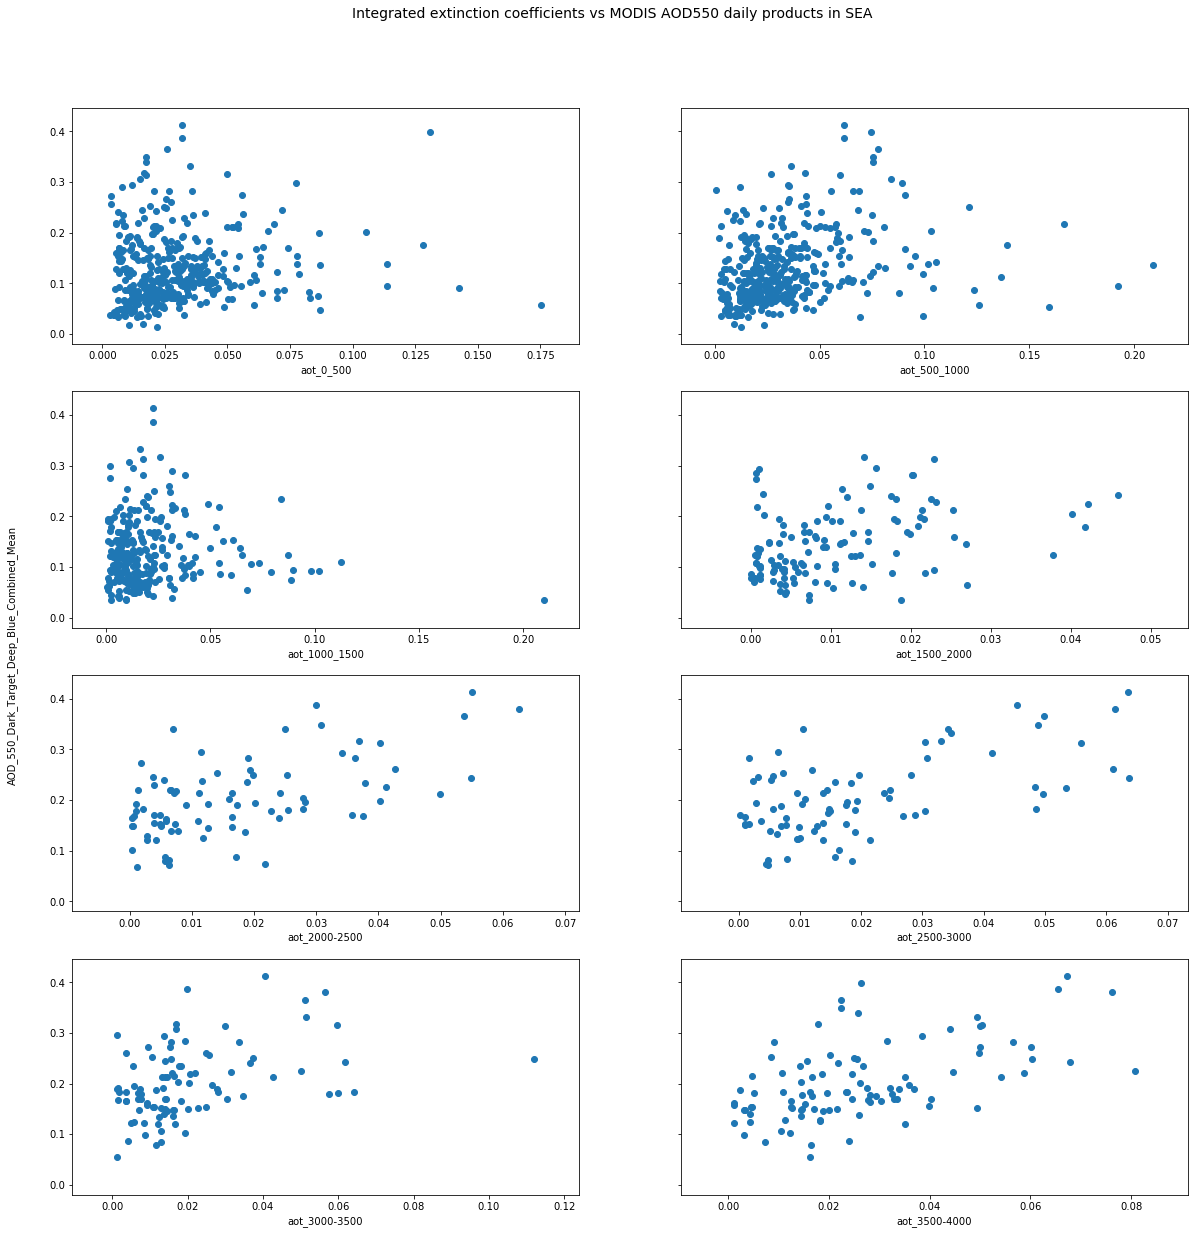

In [386]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharey=True)

plt.suptitle('Integrated extinction coefficients vs MODIS AOD550 daily products in SEA', y=0.95, fontsize=14)

axes[0, 0].scatter(col_aots_aod550_sea[0].data, col_aots_aod550_sea[-1].data)
axes[0, 0].set_xlabel(col_aots_aod550_sea[0].var_name)

axes[0, 1].scatter(col_aots_aod550_sea[1].data, col_aots_aod550_sea[-1].data)
axes[0, 1].set_xlabel(col_aots_aod550_sea[1].var_name)

axes[1, 0].scatter(col_aots_aod550_sea[2].data, col_aots_aod550_sea[-1].data)
axes[1, 0].set_xlabel(col_aots_aod550_sea[2].var_name)

axes[1, 1].scatter(col_aots_aod550_sea[3].data, col_aots_aod550_sea[-1].data)
axes[1, 1].set_xlabel(col_aots_aod550_sea[3].var_name)

axes[2, 0].scatter(col_aots_aod550_sea[4].data, col_aots_aod550_sea[-1].data)
axes[2, 0].set_xlabel(col_aots_aod550_sea[4].var_name)

axes[2, 1].scatter(col_aots_aod550_sea[5].data, col_aots_aod550_sea[-1].data)
axes[2, 1].set_xlabel(col_aots_aod550_sea[5].var_name)

axes[3, 0].scatter(col_aots_aod550_sea[6].data, col_aots_aod550_sea[-1].data)
axes[3, 0].set_xlabel(col_aots_aod550_sea[6].var_name)

axes[3, 1].scatter(col_aots_aod550_sea[7].data, col_aots_aod550_sea[-1].data)
axes[3, 1].set_xlabel(col_aots_aod550_sea[7].var_name)

# plt.setp(axes, xlim=(-0.01, 0.35), ylim=(0, 0.35))
fig.text(0.08, 0.5, col_aots_aod550_sea[-1].var_name, va='center', rotation='vertical')
plt.show()

### Collocate ungridded AOTs with Nd calculated from MODIS daily data

In [358]:
with open('data/subsets/Nd_sea_cube_jan_2010.pkl', 'rb') as b:
    Nd_sea_cube = pickle.load(b)

In [359]:
with open('data/subsets/Nd_sea_cube_jan_2010.pkl', 'rb') as b:
    Nd_peru_cube = pickle.load(b)

In [360]:
Nd_sea_cube.var_name = 'Nd'
Nd_peru_cube.var_name = 'Nd'

In [361]:
Nd_grid_peru = GriddedData.make_from_cube(Nd_peru_cube)
Nd_grid_sea = GriddedData.make_from_cube(Nd_sea_cube)

In [20]:
Nd_sea_jan_mean = Nd_sea_cube.collapsed('time', iris.analysis.MEAN)
Nd_peru_jan_mean = Nd_peru_cube.collapsed('time', iris.analysis.MEAN)


In [21]:
Nd_sea_jan_std = Nd_sea_cube.collapsed('time', iris.analysis.STD_DEV)
Nd_peru_jan_std = Nd_peru_cube.collapsed('time', iris.analysis.STD_DEV)

Forgive the messed up colorbars, just needed a quick show of Nd...

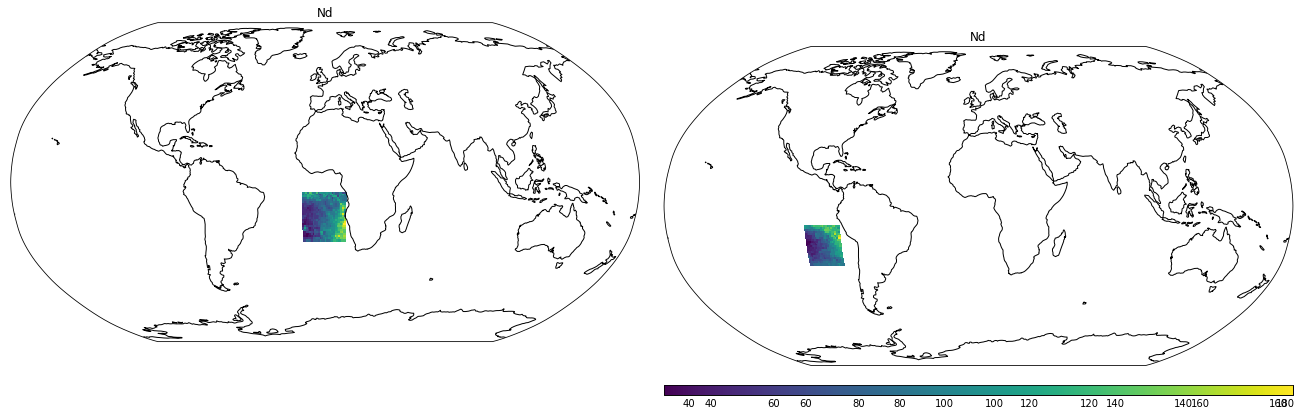

In [357]:
import cartopy.crs as ccrs
import iris.quickplot as qplt

fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

axes[0].set_global()
axes[0].coastlines()
qplt.pcolormesh(Nd_sea_jan_mean[0], axes=axes[0], cmap='viridis')

axes[1].set_global()
axes[1].coastlines()
qplt.pcolormesh(Nd_peru_jan_mean[0], axes=axes[1], cmap='viridis')

qplt.show()

In [362]:
# this is currently necessary for collocation to work 
Nd_grid_sea.transpose()
Nd_grid_peru.transpose()

In [379]:
aots_peru_col = peru_aots.collocated_onto(Nd_grid_peru, missing_data_for_missing_sample=False)

In [380]:
col_aots_nd_peru = aots_peru_col[::3]
col_aots_nd_peru.append(Nd_grid_peru)

There don't seem to be any data points to match the calculated Nd and integrated extinctions in this region...

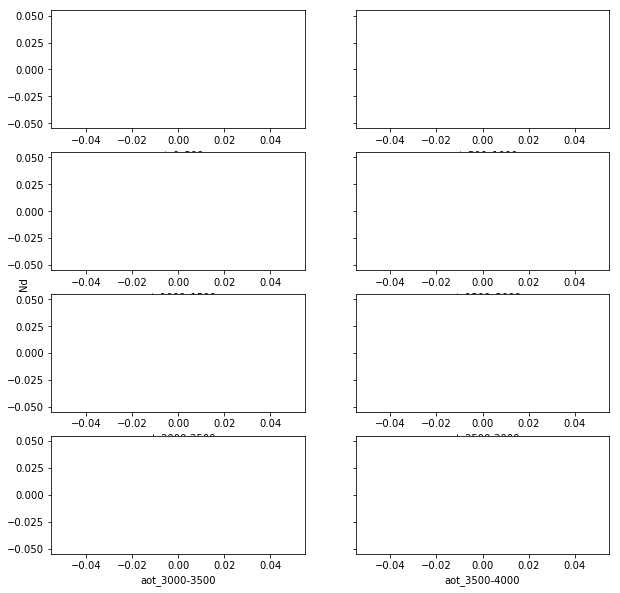

In [382]:
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)

axes[0, 0].scatter(col_aots_nd_peru[0].data, col_aots_nd_peru[-1].data)
axes[0, 0].set_xlabel(col_aots_nd_peru[0].var_name)

axes[0, 1].scatter(col_aots_nd_peru[1].data, col_aots_nd_peru[-1].data)
axes[0, 1].set_xlabel(col_aots_nd_peru[1].var_name)

axes[1, 0].scatter(col_aots_nd_peru[2].data, col_aots_nd_peru[-1].data)
axes[1, 0].set_xlabel(col_aots_nd_peru[2].var_name)

axes[1, 1].scatter(col_aots_nd_peru[3].data, col_aots_nd_peru[-1].data)
axes[1, 1].set_xlabel(col_aots_nd_peru[3].var_name)

axes[2, 0].scatter(col_aots_nd_peru[4].data, col_aots_nd_peru[-1].data)
axes[2, 0].set_xlabel(col_aots_nd_peru[4].var_name)

axes[2, 1].scatter(col_aots_nd_peru[5].data, col_aots_nd_peru[-1].data)
axes[2, 1].set_xlabel(col_aots_nd_peru[5].var_name)

axes[3, 0].scatter(col_aots_nd_peru[6].data, col_aots_nd_peru[-1].data)
axes[3, 0].set_xlabel(col_aots_nd_peru[6].var_name)

axes[3, 1].scatter(col_aots_nd_peru[7].data, col_aots_nd_peru[-1].data)
axes[3, 1].set_xlabel(col_aots_nd_peru[7].var_name)

# plt.setp(axes, xlim=(-0.01, 0.35), ylim=(0, 0.35))
fig.text(0.08, 0.5, col_aots_nd_peru[-1].var_name, va='center', rotation='vertical')
plt.show()

In [369]:
aots_sea_col = sea_aots.collocated_onto(Nd_grid_peru, missing_data_for_missing_sample=False)

In [370]:
col_aots_nd_sea = aots_sea_col[::3]
col_aots_nd_sea.append(Nd_grid_sea)

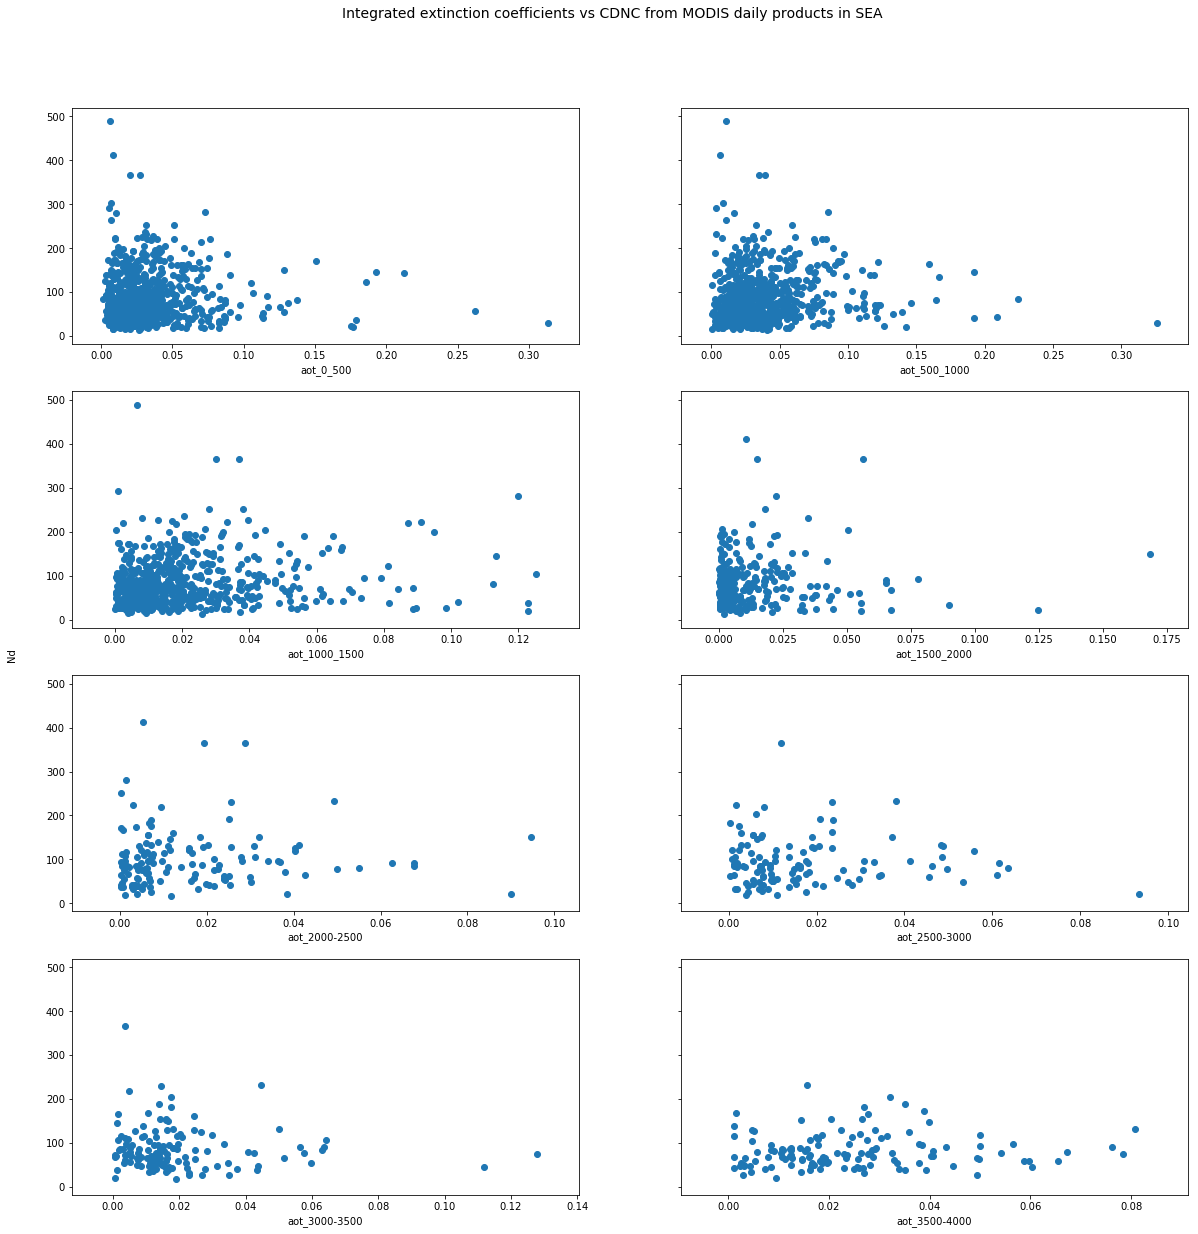

In [378]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharey=True)

plt.suptitle('Integrated extinction coefficients vs CDNC from MODIS daily products in SEA', y=0.95, fontsize=14)

axes[0, 0].scatter(col_aots_nd_sea[0].data, col_aots_nd_sea[-1].data)
axes[0, 0].set_xlabel(col_aots_nd_sea[0].var_name)

axes[0, 1].scatter(col_aots_nd_sea[1].data, col_aots_nd_sea[-1].data)
axes[0, 1].set_xlabel(col_aots_nd_sea[1].var_name)

axes[1, 0].scatter(col_aots_nd_sea[2].data, col_aots_nd_sea[-1].data)
axes[1, 0].set_xlabel(col_aots_nd_sea[2].var_name)

axes[1, 1].scatter(col_aots_nd_sea[3].data, col_aots_nd_sea[-1].data)
axes[1, 1].set_xlabel(col_aots_nd_sea[3].var_name)

axes[2, 0].scatter(col_aots_nd_sea[4].data, col_aots_nd_sea[-1].data)
axes[2, 0].set_xlabel(col_aots_nd_sea[4].var_name)

axes[2, 1].scatter(col_aots_nd_sea[5].data, col_aots_nd_sea[-1].data)
axes[2, 1].set_xlabel(col_aots_nd_sea[5].var_name)

axes[3, 0].scatter(col_aots_nd_sea[6].data, col_aots_nd_sea[-1].data)
axes[3, 0].set_xlabel(col_aots_nd_sea[6].var_name)

axes[3, 1].scatter(col_aots_nd_sea[7].data, col_aots_nd_sea[-1].data)
axes[3, 1].set_xlabel(col_aots_nd_sea[7].var_name)

# plt.setp(axes, xlim=(-0.01, 0.35), ylim=(0, 0.35))
fig.text(0.08, 0.5, col_aots_nd_sea[-1].var_name, va='center', rotation='vertical')
plt.show()